### Load libraries

In [1]:
import numpy as np
from sklearn.metrics import auc
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,classification_report
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.semi_supervised import LabelPropagation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from node2vec import Node2Vec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, roc_curve, precision_recall_curve


### Get network and data exploration

In [2]:
# read in network data file
biogrid_raw = pd.read_csv("../data/bigdatasets/biogrid_network.txt", sep='\t') 

#take a look
biogrid_raw.head()

,#ID Interactor A,ID Interactor B,Alt IDs Interactor A,Alt IDs Interactor B,Aliases Interactor A,Aliases Interactor B,Interaction Detection Method,Publication 1st Author,Publication Identifiers,Taxid Interactor A,Taxid Interactor B,Interaction Types,Source Database,Interaction Identifiers,Confidence Values
0,entrez gene/locuslink:6416,entrez gene/locuslink:2318,biogrid:112315|entrez gene/locuslink:MAP2K4|un...,biogrid:108607|entrez gene/locuslink:FLNC|unip...,entrez gene/locuslink:JNKK(gene name synonym)|...,entrez gene/locuslink:ABP-280(gene name synony...,"psi-mi:""MI:0018""(two hybrid)",Marti A (1997),pubmed:9006895,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:103,-
1,entrez gene/locuslink:84665,entrez gene/locuslink:88,biogrid:124185|entrez gene/locuslink:MYPN|unip...,biogrid:106603|entrez gene/locuslink:ACTN2|uni...,entrez gene/locuslink:CMD1DD(gene name synonym...,entrez gene/locuslink:CMD1AA(gene name synonym),"psi-mi:""MI:0018""(two hybrid)",Bang ML (2001),pubmed:11309420,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:117,-
2,entrez gene/locuslink:90,entrez gene/locuslink:2339,biogrid:106605|entrez gene/locuslink:ACVR1|uni...,biogrid:108625|entrez gene/locuslink:FNTA|unip...,entrez gene/locuslink:ACTRI(gene name synonym)...,entrez gene/locuslink:FPTA(gene name synonym)|...,"psi-mi:""MI:0018""(two hybrid)",Wang T (1996),pubmed:8599089,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:183,-
3,entrez gene/locuslink:2624,entrez gene/locuslink:5371,biogrid:108894|entrez gene/locuslink:GATA2|uni...,biogrid:111384|entrez gene/locuslink:PML|unipr...,entrez gene/locuslink:DCML(gene name synonym)|...,entrez gene/locuslink:MYL(gene name synonym)|e...,"psi-mi:""MI:0018""(two hybrid)",Tsuzuki S (2000),pubmed:10938104,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:278,-
4,entrez gene/locuslink:6118,entrez gene/locuslink:6774,biogrid:112038|entrez gene/locuslink:RPA2|entr...,biogrid:112651|entrez gene/locuslink:STAT3|uni...,entrez gene/locuslink:REPA2(gene name synonym)...,entrez gene/locuslink:ADMIO(gene name synonym)...,"psi-mi:""MI:0018""(two hybrid)",Kim J (2000),pubmed:10875894,taxid:9606,taxid:9606,"psi-mi:""MI:0407""(direct interaction)","psi-mi:""MI:0463""(biogrid)",biogrid:418,-


In [3]:
# look at column names
biogrid_raw.columns.tolist()

['#ID Interactor A',
 'ID Interactor B',
 'Alt IDs Interactor A',
 'Alt IDs Interactor B',
 'Aliases Interactor A',
 'Aliases Interactor B',
 'Interaction Detection Method',
 'Publication 1st Author',
 'Publication Identifiers',
 'Taxid Interactor A',
 'Taxid Interactor B',
 'Interaction Types',
 'Source Database',
 'Interaction Identifiers',
 'Confidence Values']

In [4]:
# biogrid has proteins for other species. I want only the human proteins so filter these out.
human_biogrid_raw =biogrid_raw[(biogrid_raw['Taxid Interactor A'] == "taxid:9606") & (biogrid_raw['Taxid Interactor B'] == "taxid:9606")]

In [5]:
# Further data exploration. Check for nas, shape of data
# check for nas
human_biogrid_raw.head()
human_biogrid_raw.shape

human_biogrid_raw.describe()
print(human_biogrid_raw.isna().any())

print("Shape of dataframe", human_biogrid_raw.shape)

#ID Interactor A                False
ID Interactor B                 False
Alt IDs Interactor A            False
Alt IDs Interactor B            False
Aliases Interactor A            False
Aliases Interactor B            False
Interaction Detection Method    False
Publication 1st Author           True
Publication Identifiers         False
Taxid Interactor A              False
Taxid Interactor B              False
Interaction Types               False
Source Database                 False
Interaction Identifiers         False
Confidence Values               False
dtype: bool
Shape of dataframe (1131384, 15)


In [6]:
# get rid of umwanted columns
columns_to_drop= ['Alt IDs Interactor A',
 'Alt IDs Interactor B',
 'Aliases Interactor A',
 'Aliases Interactor B',
 'Interaction Detection Method',
 'Publication 1st Author',
 'Publication Identifiers',
 'Taxid Interactor A',
 'Taxid Interactor B','Interaction Types',
 'Source Database',
 'Interaction Identifiers']
human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)

human_biogrid_raw.head()
print("Shape of dataframe", human_biogrid_raw.shape)

Shape of dataframe (1131384, 3)


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_94422/1794002502.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  human_biogrid_raw.drop(columns=columns_to_drop, inplace=True)


In [7]:
human_biogrid_raw.head()

,#ID Interactor A,ID Interactor B,Confidence Values
0,entrez gene/locuslink:6416,entrez gene/locuslink:2318,-
1,entrez gene/locuslink:84665,entrez gene/locuslink:88,-
2,entrez gene/locuslink:90,entrez gene/locuslink:2339,-
3,entrez gene/locuslink:2624,entrez gene/locuslink:5371,-
4,entrez gene/locuslink:6118,entrez gene/locuslink:6774,-


In [8]:
# format values in the confidence values so only the numeric part is kept

#checking for na scores. NA scores are represented with '-'
look_at_score =human_biogrid_raw["Confidence Values"].unique()
# for score in look_at_score:
#     print(score)

#remove the score part
human_biogrid_raw.loc[:,'Confidence Values'] = human_biogrid_raw['Confidence Values'].str.replace('score:', '') 
    
print(human_biogrid_raw.dtypes)
#get rid of any rows that have '-' in the confidence value
filtered_biogrid = human_biogrid_raw[human_biogrid_raw['Confidence Values'] != "-"]

# ensure correct data type for the confidence scores.
filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)
print("After changing dat types \n", filtered_biogrid.dtypes)


#ID Interactor A     object
ID Interactor B      object
Confidence Values    object
dtype: object
After changing dat types 
 #ID Interactor A      object
ID Interactor B       object
Confidence Values    float64
dtype: object


/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_94422/4262132236.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Confidence Values'] = filtered_biogrid['Confidence Values'].astype(float)


In [9]:
# now doing the same for the genes in interactor a and b columns
filtered_biogrid.loc[:, '#ID Interactor A'] = filtered_biogrid['#ID Interactor A'].str.split(':').str[-1]

filtered_biogrid.loc[:, 'ID Interactor B'] = filtered_biogrid['ID Interactor B'].str.split(':').str[-1]

In [10]:
# check data frame
filtered_biogrid.head()

# check data type of columns
print("Check data type", filtered_biogrid.dtypes)

Check data type #ID Interactor A      object
ID Interactor B       object
Confidence Values    float64
dtype: object


In [11]:
# check range of confidence values
max_conf_values = filtered_biogrid['Confidence Values'].max()
min_conf_values = filtered_biogrid['Confidence Values'].min()

print(f"Max confidence value { max_conf_values} and min confidence value {min_conf_values}")

Max confidence value 52530.0 and min confidence value -24.621


In [12]:
# Scale confidence values to improve model performance

scale = StandardScaler()
filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))

/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_94422/3134063215.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid['Standardized_confidence_values'] = scale.fit_transform(filtered_biogrid['Confidence Values'].values.reshape(-1, 1))


In [13]:
# check range of confidence values
filtered_biogrid.describe()

,Confidence Values,Standardized_confidence_values
count,401541.000000,4.015410e+05
mean,23.642792,3.006669e-17
std,319.259313,1.000001e+00
min,-24.621000,-1.511745e-01
25%,0.893457,-7.125670e-02
50%,0.992166,-7.094751e-02
75%,1.000000,-7.092298e-02
max,52530.000000,1.644632e+02


In [14]:
# view data frame
filtered_biogrid.head(20)

,#ID Interactor A,ID Interactor B,Confidence Values,Standardized_confidence_values
121446,10421,23020,1.000,-0.070923
121447,10755,4646,0.952,-0.071073
121448,1974,1981,0.931,-0.071139
121449,10421,10594,0.919,-0.071177
121450,382,10128,0.909,-0.071208
121451,7532,3799,0.900,-0.071236
121452,9337,23019,0.899,-0.071239
121453,55723,79711,0.794,-0.071568
121454,28988,8924,0.783,-0.071603
121455,9410,10594,0.780,-0.071612


In [15]:
# drop confidence values column and only keep the standardized values
filtered_biogrid.drop(columns='Confidence Values', inplace=True)

filtered_biogrid.head(20)

/var/folders/9q/tl4z5rk169514hgp4blpglqc0000gn/T/ipykernel_94422/1340739942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_biogrid.drop(columns='Confidence Values', inplace=True)


,#ID Interactor A,ID Interactor B,Standardized_confidence_values
121446,10421,23020,-0.070923
121447,10755,4646,-0.071073
121448,1974,1981,-0.071139
121449,10421,10594,-0.071177
121450,382,10128,-0.071208
121451,7532,3799,-0.071236
121452,9337,23019,-0.071239
121453,55723,79711,-0.071568
121454,28988,8924,-0.071603
121455,9410,10594,-0.071612


In [16]:
# check one more time for nas
print(filtered_biogrid.isna().any())

#ID Interactor A                  False
ID Interactor B                   False
Standardized_confidence_values    False
dtype: bool


### Prepare biogrid data for model training and testing sets -> keep only genes that are connected, get adjacency matrix and embed the adjacency matrix

In [17]:
# need to get the adjecancy matrix of the biogrid data frame

# first check to see if the edge list results in a connected graph
graph = nx.from_pandas_edgelist(filtered_biogrid, '#ID Interactor A', 'ID Interactor B')
is_connected = nx.is_connected(graph)
print(is_connected)
# output whether the graph is connected or not
if is_connected:
    print("The Human BioGRID network is fully connected.")
else:
    print("The Human BioGRID network is not fully connected.")

# find the connected components
connected_components = list(nx.connected_components(graph))

# get the largest connected component
largest_component = max(connected_components, key=len)
print(f"Largest component size: {len(largest_component)}.")

# keep only interactions within the largest connected component
only_connected_biogrid = filtered_biogrid[
    (filtered_biogrid['#ID Interactor A'].isin(largest_component)) &
    (filtered_biogrid['ID Interactor B'].isin(largest_component))
]

# start building the adjacency matrix
num_genes = len(largest_component)
adj_matrix = np.zeros((num_genes, num_genes))

# create a mapping of genes to indices
gene_to_index = {gene: i for i, gene in enumerate(largest_component)}

# iterate through the df to fill the adjacency matrix
for _, row in only_connected_biogrid.iterrows():
    gene_a_index = gene_to_index.get(row['#ID Interactor A'])
    gene_b_index = gene_to_index.get(row['ID Interactor B'])
    confidence_value = row['Standardized_confidence_values']
    if not np.isnan(confidence_value):
        adj_matrix[gene_a_index, gene_b_index] = confidence_value
        adj_matrix[gene_b_index, gene_a_index] = confidence_value  

# check for rows in the adjacency matrix that have all zeros
rows_with_all_zeros = np.where(~adj_matrix.any(axis=1))[0]

if len(rows_with_all_zeros) > 0:
    print("Rows with all zeros found at indices:", rows_with_all_zeros)
else:
    print("No rows with all zeros found.")
    
new_graph = nx.from_pandas_edgelist(only_connected_biogrid, '#ID Interactor A', 'ID Interactor B')
is_connected = nx.is_connected(new_graph)
print(is_connected)
# output whether the graph is connected or not
if is_connected:
    print("The Human BioGRID network is fully connected.")
else:
    print("The Human BioGRID network is not fully connected.")


False
The Human BioGRID network is not fully connected.
Largest component size: 15800.
No rows with all zeros found.
True
The Human BioGRID network is fully connected.


In [18]:
print(f"The shape of the Biogrid adjacency is {adj_matrix.shape}.")
# # printing first 3 rows and all columns to take a look at the adjacency matrix to ensure correct format
# with open('adjacency_matrix.txt', 'w') as f:
#     for row in adj_matrix[:3]:
#         f.write(' '.join(map(str, row)) + '\n\n\n\n\n\n\n')


The shape of the Biogrid adjacency is (15800, 15800).


In [19]:
#create embeddings for adj matrix
def get_embeddings(matrix):
    # initialize graph for adj matrix
    graph = nx.Graph()

    # add edges from the adjacency matrix to the graph
    num_nodes = matrix.shape[0]
    print("Number of nodes in the graph:", num_nodes)
    for i in range(num_nodes):
        for j in range(num_nodes):
            if matrix[i, j] != 0:  # include only all non-zero values
                graph.add_edge(i, j, weight=matrix[i, j])

    print(f"num_nodes value: {num_nodes}")
    print(f"graph_features value:  {graph.number_of_nodes()}")

    # generate embeddings
    node2vec = Node2Vec(graph, dimensions=64, walk_length=100, num_walks=20, workers=4)
    model_features = node2vec.fit(window=10, min_count=1)

    embeddings = np.array([model_features.wv[str(node)] for node in graph.nodes()])

    print(f"Shape of feature_embeddings:{embeddings.shape}")
    
    return(embeddings)

adj_matrix_embeddings = get_embeddings(adj_matrix)



Number of nodes in the graph: 15800
num_nodes value: 15800
graph_features value:  15800


Computing transition probabilities:   0%|          | 0/15800 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 5/5 [01:53<00:00, 22.65s/it]


Shape of feature_embeddings:(15800, 64)


### Load HPO and DisGeNET genes

In [20]:
# read in disgnet disease gene associations
disgenet_raw = pd.read_csv('../data/processed/tb_propagated_disgenet_genes.tsv', delimiter= '\t')
disgenet_raw.head(15)

,gene_id,mondo_id,mondo_term
0,10,MONDO:0018076,tuberculosis
1,100,MONDO:0018076,tuberculosis
2,181,MONDO:0018076,tuberculosis
3,820,MONDO:0018076,tuberculosis
4,847,MONDO:0018076,tuberculosis
5,929,MONDO:0018076,tuberculosis
6,1401,MONDO:0018076,tuberculosis
7,1555,MONDO:0018076,tuberculosis
8,1571,MONDO:0018076,tuberculosis
9,1999,MONDO:0018076,tuberculosis


In [21]:
disgenet_raw.shape

(106, 3)

In [22]:
# place the tb genes in a list and mark as positive genes
tb_pos_disgenes = [str(gene) for gene in set(disgenet_raw['gene_id'].tolist())]
print(tb_pos_disgenes)

['3586', '3593', '10', '3594', '345611', '1555', '3605', '3606', '27161', '23583', '3105', '1571', '3623', '3627', '101927980', '3119', '2096', '3123', '3125', '3127', '4153', '646730', '5199', '7248', '7249', '3663', '6737', '51284', '343641', '30813', '100', '27241', '54892', '30835', '6774', '50807', '64127', '8838', '2213', '3240', '3242', '181', '59067', '9927', '6347', '717', '6352', '4312', '4318', '4843', '54509', '1786', '7421', '50943', '3329', '10529', '129831', '79659', '820', '9021', '80196', '80712', '3918', '847', '9048', '54106', '9564', '1380', '3431', '25966', '3439', '6002', '3447', '1401', '7040', '3458', '3459', '11151', '57232', '4498', '6556', '1437', '929', '5027', '5034', '114609', '7096', '7097', '50616', '7099', '959', '27074', '4045', '1999', '50639', '7124', '3552', '3553', '105374693', '3558', '3560', '8170', '3565', '3569', '7153', '3576']


In [23]:
# read hpo data
hpo_raw = pd.read_csv('../data/processed/propagated_hpo_genes.tsv', delimiter= '\t')
hpo_raw.head()

,hpo_id,hpo_name,gene_id
0,HP:0001894,Thrombocytosis,3459
1,HP:0003621,Juvenile onset,6772
2,HP:0002840,Lymphadenitis,3394
3,HP:0002719,Recurrent infections,3594
4,HP:0020086,BCGitis,3593


In [24]:
print(hpo_raw.shape)

(7418, 3)


In [25]:
tb_pos_hpo =[str(gene) for gene in set(hpo_raw['gene_id'].tolist())]
print(type(tb_pos_hpo[0]))

<class 'str'>


### Declare the positive and negative training samples

In [26]:
# function that will check to see if the positive genes are in the network. 
# If they are not in the network then they are taken out. Keep track of which genes are removed

def genes_in_network(positive_list, genes_to_index, adjacency_matrix):
    # get the set of genes that are in the new adjacency matrix
    genes_in_network_set = set(genes_to_index.keys())

    removed_genes = []
    
    # keep genes in the positive list if they are found in the network
    filtered_positive_list = []
    for gene in positive_list:
        if gene in genes_in_network_set:
            filtered_positive_list.append(gene)
        else:
            removed_genes.append(gene)
        
     # get the indexes of the the negative genes to get them from the adj matrix
    positive_indices = [genes_to_index[gene] for gene in filtered_positive_list]
    
    # get the negative gene subset from the adjacency matrix 
    positive_adjacency_matrix = adjacency_matrix[positive_indices, :]
    
    # make new gene to index dictionary containing only the negative genes
    positive_gene_to_index = {gene: genes_to_index[gene] for gene in positive_list if gene in genes_to_index}

    # since shape of adj matrix changed, have to start new indexes
    new_positive_indices = list(range(positive_adjacency_matrix.shape[0]))

    # make new gene to index dictionary containing only the negative genes
    new_positive_gene_to_index = {gene: index for index, gene in enumerate(filtered_positive_list)}


    

    return filtered_positive_list, removed_genes, positive_adjacency_matrix, positive_gene_to_index, new_positive_gene_to_index




In [27]:
# keep only genes that are in the network for the positives and unlabled
tb_disgenet_pos, removed_disgenet_genes, tb_pos_disgenet_features, disgenet_posgen2ind, new_disgenet_posgen2ind = genes_in_network(tb_pos_disgenes, gene_to_index, adj_matrix_embeddings)
tb_hpo_pos, removed_hpo_genes, tb_pos_hpo_features, hpo_posgen2in, new_hpo_posgen2in = genes_in_network(tb_pos_hpo, gene_to_index, adj_matrix_embeddings)


In [28]:
# get some quick counts on genes in and out of network

print(f"Positive genes in network for DisGeNET: {len(tb_disgenet_pos)}")
print(f"Positve genes in network for HPO: {len(tb_hpo_pos)}\n")

print(f"Genes not in network for DisGeNET set: {len(removed_disgenet_genes)}")
print(f"Genes not in network for HPO {len(removed_hpo_genes)}\n")

print(f"Positve gene tb disgenet list {tb_pos_disgenes}")
print(f"new pos disgenet gene2indices {new_disgenet_posgen2ind}")

Positive genes in network for DisGeNET: 86
Positve genes in network for HPO: 4264

Genes not in network for DisGeNET set: 20
Genes not in network for HPO 590

Positve gene tb disgenet list ['3586', '3593', '10', '3594', '345611', '1555', '3605', '3606', '27161', '23583', '3105', '1571', '3623', '3627', '101927980', '3119', '2096', '3123', '3125', '3127', '4153', '646730', '5199', '7248', '7249', '3663', '6737', '51284', '343641', '30813', '100', '27241', '54892', '30835', '6774', '50807', '64127', '8838', '2213', '3240', '3242', '181', '59067', '9927', '6347', '717', '6352', '4312', '4318', '4843', '54509', '1786', '7421', '50943', '3329', '10529', '129831', '79659', '820', '9021', '80196', '80712', '3918', '847', '9048', '54106', '9564', '1380', '3431', '25966', '3439', '6002', '3447', '1401', '7040', '3458', '3459', '11151', '57232', '4498', '6556', '1437', '929', '5027', '5034', '114609', '7096', '7097', '50616', '7099', '959', '27074', '4045', '1999', '50639', '7124', '3552', '3553

In [29]:
# check to see if gene sin negative set are in the new genest_to_index for the negative set
key_to_check = '3593'
if key_to_check in new_disgenet_posgen2ind:
    print("Value for key '{}': {}".format(key_to_check, new_disgenet_posgen2ind[key_to_check]))
else:
    print("Key '{}' is not present in the dictionary.".format(key_to_check))
    if key_to_check in removed_disgenet_genes:
        print("Value {} found in the removed list. This gene was not part of the network.".format(key_to_check))
    else:
        print("Value {} not found in the removed list.".format(key_to_check))
    
    
    # if not in new gene to index it may be removed so check in removed



Key '3593' is not present in the dictionary.
Value 3593 found in the removed list. This gene was not part of the network.


In [30]:
random.seed(42)
def get_negatives(positive_list, genes_to_index, adjacency_matrix):

    # get genes that are in networ
    genes_in_network = set(genes_to_index.keys())

    # take out positive genes from this universe
    genes_in_network -= set(positive_list)

    # convert dictionary to list
    genes_in_network_list = list(genes_in_network)

    # determine the number of negative genes needed
    num_negative_genes_needed = len(positive_list)

    # filter out negative genes not in the network
    negative_list = [gene for gene in genes_in_network_list if gene in genes_to_index]

    # randomly select negative genes to match the number of positive genes
    negative_list = random.sample(genes_in_network_list, num_negative_genes_needed)

    # get the indexes of the the negative genes to get them from the adj matrix
    negative_indices = [genes_to_index[gene] for gene in negative_list]
    
    # get the negative gene subset from the adjacency matrix 
    negative_adjacency_matrix = adjacency_matrix[negative_indices, :]

    # make new gene to index dictionary containing only the negative genes
    negative_gene_to_index = {gene: genes_to_index[gene] for gene in negative_list if gene in genes_to_index}

    # since shape of adj matrix changed, have to start new indexes
    new_negative_indices = list(range(negative_adjacency_matrix.shape[0]))

    # make new gene to index dictionary containing only the negative genes
    new_negative_gene_to_index = {gene: index for index, gene in enumerate(negative_list)}

    return negative_list, negative_adjacency_matrix, negative_gene_to_index, new_negative_gene_to_index


In [31]:
# get negative list
random.seed(42)
tb_disgenet_neg_list, tb_disgenet_neg_feat, old_disgenet_negind, disgenet_neg_gene2ind = get_negatives(tb_disgenet_pos, gene_to_index, adj_matrix_embeddings)
tb_hpo_neg_list, tb_hpo_neg_feat, old_hpo_negind, hpo_neg_gene2ind = get_negatives(tb_hpo_pos, gene_to_index, adj_matrix_embeddings)

In [32]:
# get quick count to make sure the negatives match the number of positives
print(f"Negative genes in network for DisGeNET: {len(tb_disgenet_neg_list)} {tb_disgenet_neg_list}")
print(f"Negative genes in network for HPO: {len(tb_hpo_neg_list)}")
print(f"adj_matrix for hpo negatives shape and view: {tb_hpo_neg_feat.shape} {tb_hpo_neg_feat}")
print(f"adj_matrix for disgenet negatives shape and view: {tb_disgenet_neg_feat.shape} {tb_disgenet_neg_feat}")
print(disgenet_neg_gene2ind)

Negative genes in network for DisGeNET: 86 ['24148', '50964', '3507', '80831', '23072', '56139', '4072', '11091', '78994', '10691', '27339', '257160', '5099', '10562', '5284', '55160', '10926', '10793', '51651', '150082', '2990', '123041', '104', '9552', '479', '55233', '440434', '5828', '11316', '149483', '114783', '11281', '738', '51032', '55776', '9890', '6874', '3069', '25996', '353345', '4841', '4317', '9185', '4151', '7682', '5511', '4863', '3066', '79022', '5260', '23181', '146880', '65996', '5028', '326625', '3834', '54904', '388965', '81550', '307', '84251', '85465', '2153', '1008', '29940', '80219', '11097', '56256', '63939', '6892', '84542', '284498', '80125', '9024', '51088', '2021', '5441', '51082', '8914', '5087', '5689', '342945', '9463', '51458', '489', '3850']
Negative genes in network for HPO: 4264
adj_matrix for hpo negatives shape and view: (4264, 64) [[-0.03470125  0.2610064  -0.03996613 ... -0.264518    0.3225835
   0.72764415]
 [-0.01994832 -0.43829513 -0.2587149

In [33]:
# check to see if gene sin negative set are in the new genest_to_index for the negative set
key_to_check = '6533'
if key_to_check in disgenet_neg_gene2ind:
    print("Value for key '{}': {}".format(key_to_check, disgenet_neg_gene2ind[key_to_check]))
else:
    print("Key '{}' is not present in the dictionary.".format(key_to_check))


Key '6533' is not present in the dictionary.


In [34]:
print(tb_disgenet_neg_list)
print(tb_disgenet_pos)

# check to see if the list share any genes
intersection = np.intersect1d(tb_disgenet_neg_list, tb_disgenet_pos)

if len(intersection) == 0:
    print("tb_disgenet_neg_list and tb_disgenet_pos do not share any values.")
else:
    print("tb_disgenet_neg_list and tb_disgenet_pos share values.")


['24148', '50964', '3507', '80831', '23072', '56139', '4072', '11091', '78994', '10691', '27339', '257160', '5099', '10562', '5284', '55160', '10926', '10793', '51651', '150082', '2990', '123041', '104', '9552', '479', '55233', '440434', '5828', '11316', '149483', '114783', '11281', '738', '51032', '55776', '9890', '6874', '3069', '25996', '353345', '4841', '4317', '9185', '4151', '7682', '5511', '4863', '3066', '79022', '5260', '23181', '146880', '65996', '5028', '326625', '3834', '54904', '388965', '81550', '307', '84251', '85465', '2153', '1008', '29940', '80219', '11097', '56256', '63939', '6892', '84542', '284498', '80125', '9024', '51088', '2021', '5441', '51082', '8914', '5087', '5689', '342945', '9463', '51458', '489', '3850']
['3586', '10', '3594', '345611', '1555', '3605', '3606', '27161', '23583', '3105', '1571', '3623', '3627', '3119', '3123', '3125', '3127', '4153', '5199', '7248', '7249', '6737', '51284', '30813', '100', '27241', '54892', '30835', '6774', '50807', '64127'

### Get feature matrix for each data set

In [35]:
def get_feat_matrix(pos_adj_mat, neg_adj_mat, pos_gene2ind, neg_gene2ind):
    # assign labels to positive genes = 1
    pos_gene2ind_labeled = {gene: [index, 1] for gene, index in pos_gene2ind.items()}
    
    # assign labels to negative genes = 0
    neg_gene2ind_labeled = {gene: [index, 0] for gene, index in neg_gene2ind.items()}
    
    # determine the starting index for the second gene-to-index dictionary
    start_index = len(pos_gene2ind)
    print("start index:", start_index)
    print("pos_gene2ind:", pos_gene2ind_labeled)
    
    # update the index values in the second gene-to-index dictionary
    for gene, index in neg_gene2ind_labeled.items():
        index[0] += start_index  # Increment the index for negative genes
    
    print("neg_gene2ind with labels:", neg_gene2ind_labeled)
    
    # combine the two dictionaries
    combined_gene2index = {**pos_gene2ind_labeled, **neg_gene2ind_labeled}
    print("Combined gene-to-index dictionary:", combined_gene2index)
    
    # concatenate the two adjacency matrices
    combined_adj_mat = np.concatenate((pos_adj_mat, neg_adj_mat), axis=0)
    print("Combined adjacency matrix shape:", combined_adj_mat.shape)


    return combined_adj_mat, combined_gene2index



disgenet_feature_mat, disgenet_feature_gene2ind = get_feat_matrix(tb_pos_disgenet_features, tb_disgenet_neg_feat, new_disgenet_posgen2ind, disgenet_neg_gene2ind )
hpo_feature_mat, hpo_feature_gene2ind = get_feat_matrix(tb_pos_hpo_features, tb_hpo_neg_feat, new_hpo_posgen2in, hpo_neg_gene2ind)


start index: 86
pos_gene2ind: {'3586': [0, 1], '10': [1, 1], '3594': [2, 1], '345611': [3, 1], '1555': [4, 1], '3605': [5, 1], '3606': [6, 1], '27161': [7, 1], '23583': [8, 1], '3105': [9, 1], '1571': [10, 1], '3623': [11, 1], '3627': [12, 1], '3119': [13, 1], '3123': [14, 1], '3125': [15, 1], '3127': [16, 1], '4153': [17, 1], '5199': [18, 1], '7248': [19, 1], '7249': [20, 1], '6737': [21, 1], '51284': [22, 1], '30813': [23, 1], '100': [24, 1], '27241': [25, 1], '54892': [26, 1], '30835': [27, 1], '6774': [28, 1], '50807': [29, 1], '64127': [30, 1], '8838': [31, 1], '2213': [32, 1], '3240': [33, 1], '3242': [34, 1], '181': [35, 1], '59067': [36, 1], '9927': [37, 1], '6347': [38, 1], '717': [39, 1], '6352': [40, 1], '4312': [41, 1], '4318': [42, 1], '4843': [43, 1], '54509': [44, 1], '1786': [45, 1], '7421': [46, 1], '50943': [47, 1], '3329': [48, 1], '10529': [49, 1], '129831': [50, 1], '79659': [51, 1], '820': [52, 1], '9021': [53, 1], '80196': [54, 1], '3918': [55, 1], '847': [56, 1]

### Get target vectors

In [36]:
# make target vector
def get_target_vector(combined_gene2in, feature_mat):
    # initialize target vector 
    target_vector = np.zeros(len(feature_mat), dtype= int)
    index = 0

    # map gene IDs to indices and label positive samples
    for index, genes in enumerate(combined_gene2in.keys()):
        class_label = combined_gene2in.get(genes)[1]
        target_vector[index] = class_label
         
    return(target_vector)

In [37]:
disgenet_target_vector = get_target_vector(disgenet_feature_gene2ind, disgenet_feature_mat)
hpo_target_vector = get_target_vector(hpo_feature_gene2ind, hpo_feature_mat)
print("disgenet target vector and shape :{} {} ".format(disgenet_target_vector, disgenet_target_vector.shape))
print("hpo target vector and shape: {} {}".format(hpo_target_vector,hpo_target_vector.shape) )


disgenet target vector and shape :[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] (172,) 
hpo target vector and shape: [1 1 1 ... 0 0 0] (8528,)


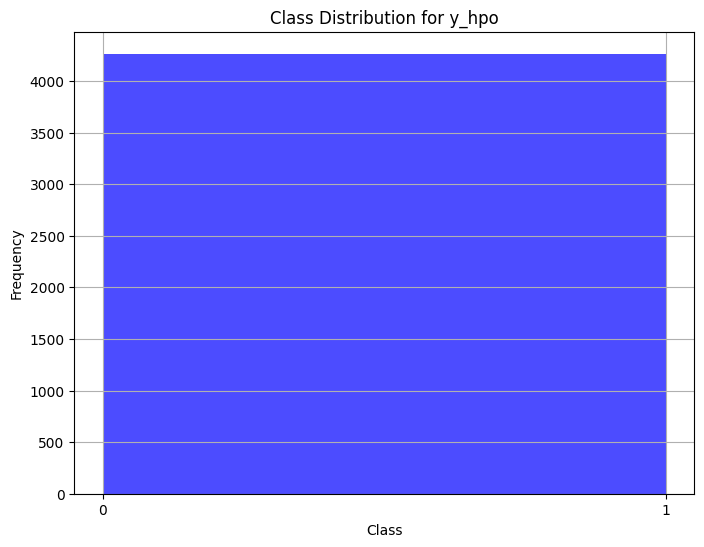

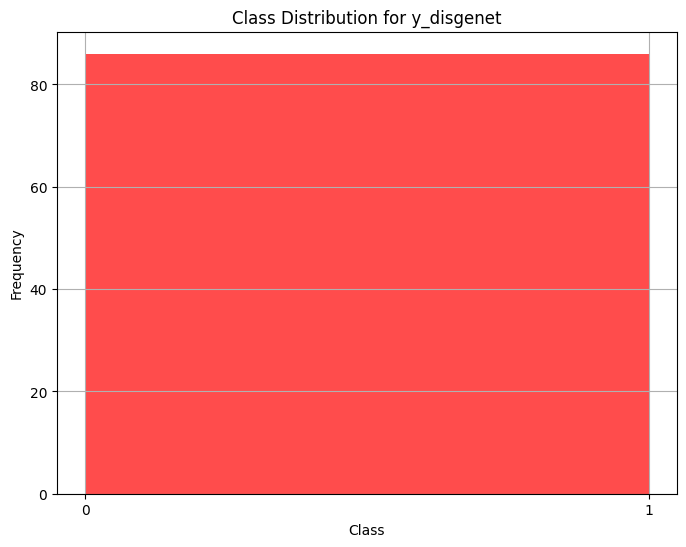

In [38]:
# plot for y_hpo
plt.figure(figsize=(8, 6))
plt.hist(hpo_target_vector, bins=2, color='blue', alpha=0.7)
plt.title('Class Distribution for y_hpo')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1])  
plt.grid(True)
plt.show()

# plot for y_disgenet
plt.figure(figsize=(8, 6))
plt.hist(disgenet_target_vector, bins=2, color='red', alpha=0.7)
plt.title('Class Distribution for y_disgenet')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1]) 
plt.grid(True)
plt.show()



In [39]:
# check target vector
print(f"Disgenet vector shape: {disgenet_target_vector.shape} and data type {type(disgenet_target_vector)}")
print(f"HPO vector shape: {hpo_target_vector.shape} and data type {type(hpo_target_vector)}")

print(adj_matrix.shape)

# file_path = "target_vector.txt"

# with open(file_path, "w") as file:
#     for value in disgenet_target_vector:
#         file.write(str(value) + "\n")

# file_path = "hpo_target_vector.txt"

# with open(file_path, "w") as file:
#     for value in hpo_target_vector:
#         file.write(str(value) + "\n")

# print("Target vector has been written to:", file_path)
##print(gene_to_index)

Disgenet vector shape: (172,) and data type <class 'numpy.ndarray'>
HPO vector shape: (8528,) and data type <class 'numpy.ndarray'>
(15800, 15800)
Target vector has been written to: hpo_target_vector.txt


### Do train and test splits

In [40]:
# declare test and train sets
print(adj_matrix_embeddings.shape)
X_disgenet = disgenet_feature_mat
X_hpo = hpo_feature_mat
y_hpo = hpo_target_vector
y_disgenet = disgenet_target_vector
print(y_disgenet.shape)
print(X_disgenet.shape)

print("Number of samples in y_disgenet:", y_disgenet.shape[0])
print("Number of samples in y_hpo:", y_hpo.shape[0])

X_train_disgenet, X_test_disgenet, y_train_disgenet, y_test_disgenet = train_test_split(X_disgenet, y_disgenet, test_size= 0.2, random_state=42, shuffle=True, stratify=y_disgenet)
X_train_hpo, X_test_hpo, y_train_hpo, y_test_hpo = train_test_split(X_hpo, y_hpo, test_size= 0.2, random_state= 42, shuffle=True, stratify=y_hpo)

new_unlabled_disgenet = adj_matrix_embeddings
new_unlabled_hpo = adj_matrix_embeddings


(15800, 64)
(172,)
(172, 64)
Number of samples in y_disgenet: 172
Number of samples in y_hpo: 8528


In [41]:
# look at the set shapes

print(f"X train disgenet shape : {X_train_disgenet.shape}")
print(f"y train disgenet shape {y_train_disgenet.shape}\n")

print(f"X test disgenet shape : {X_test_disgenet.shape}")
print(f"y test disgenet shape {y_test_disgenet.shape}\n")

print(f"X train hpo shape : {X_train_hpo.shape}")
print(f"y train hpo shape {y_train_hpo.shape}\n")

print(f"X test hpo shape : {X_test_hpo.shape}")
print(f"y test hpo shape {y_test_hpo.shape}")

X train disgenet shape : (137, 64)
y train disgenet shape (137,)

X test disgenet shape : (35, 64)
y test disgenet shape (35,)

X train hpo shape : (6822, 64)
y train hpo shape (6822,)

X test hpo shape : (1706, 64)
y test hpo shape (1706,)


### Define Models

In [52]:
# first model is using logistic regression and random forest
def logistic_regression():
    lr = LogisticRegressionCV(max_iter= 8000, multi_class= 'ovr', cv = 5,
                                   random_state= 42, penalty= 'l2')
    return(lr)

#second model is random forest 
def random_forest():
    rf = RandomForestClassifier(n_estimators= 100, bootstrap=True, min_samples_leaf=3, 
                                max_features='sqrt',random_state=42, max_depth= 10, 
                                min_samples_split=2)

    return rf

# last model is label propagation
def label_propagation():
    label_prop = LabelPropagation(kernel='knn', n_neighbors= 4, n_jobs= -2)  
    return label_prop

lr_classifier = logistic_regression()
rf_classifier = random_forest()
label_propagation = label_propagation()
    

In [53]:
#cotrain model 1 (Logistic regression and random forest)
def co_train_lr_rf(logistic_reg1, rf_class2, disgenet_labeled_dataset, hpo_labeled_dataset, disgenet_labels, hpo_labels, 
                disgenet_unlabeled, hpo_unlabeled,disgenet_test_data , hpo_test_data, disgenet_test_labels, hpo_test_labels, threshold_confidence, adj_matrix_embeddings):

    # 1. train logistic regression on labeled data
    logistic_reg1.fit(disgenet_labeled_dataset, disgenet_labels)
    rf_class2.fit(hpo_labeled_dataset, hpo_labels)

    # 2. make predictions for unlabeled data and get probabilities
    pred_probs_logistic_reg1 = logistic_reg1.predict_proba(disgenet_unlabeled)
    pred_probs_rf_class2 = rf_class2.predict_proba(hpo_unlabeled)

    # get the highest predictions
    best_logistic_reg1_labels = np.argmax(pred_probs_logistic_reg1, axis=1)
    best_rf_class2_labels = np.argmax(pred_probs_rf_class2, axis=1)


    # 3. identify confident instances and keep the ones that surpass the threshold
    confident_indices_logistic_reg1 = np.where(np.max(pred_probs_logistic_reg1, axis=1) > threshold_confidence)[0]
    confident_indices_rf_class2 = np.where(np.max(pred_probs_rf_class2, axis=1) > threshold_confidence)[0]


    # 4. update labeled data for data set with confident predictions from the other
    disgenet_labeled_dataset = np.concatenate((disgenet_labeled_dataset, disgenet_unlabeled[confident_indices_rf_class2]), axis=0)
    hpo_labeled_dataset = np.concatenate((hpo_labeled_dataset, hpo_unlabeled[confident_indices_logistic_reg1]), axis=0)

    # 5. update the labels for the labeled data
    disgenet_labels = np.concatenate((disgenet_labels, best_rf_class2_labels[confident_indices_rf_class2]), axis=0)
    hpo_labels = np.concatenate((hpo_labels, best_logistic_reg1_labels[confident_indices_logistic_reg1]), axis=0)

    # 6. retrain classifiers with updated data and labeled set
    logistic_reg1.fit(disgenet_labeled_dataset, disgenet_labels)
    rf_class2.fit(hpo_labeled_dataset, hpo_labels)

    # 7. make predictions on the test set after retraining
    test_lr_labels = logistic_reg1.predict(disgenet_test_data)
    test_rf_labels = rf_class2.predict(hpo_test_data)

    # 8. compute performance metrics
    lr_accuracy = accuracy_score(disgenet_test_labels, test_lr_labels)
    rf_accuracy = accuracy_score(hpo_test_labels, test_rf_labels)

    lr_f1_score = f1_score(test_lr_labels, disgenet_test_labels)
    rf_f1_score = f1_score(test_rf_labels, hpo_test_labels)

    lr_balanced_accuracy = balanced_accuracy_score(test_lr_labels, disgenet_test_labels)
    rf_balanced_accuracy = balanced_accuracy_score(test_rf_labels, hpo_test_labels)

    lr_precision = precision_score(test_lr_labels, disgenet_test_labels)
    rf_precision = precision_score(test_rf_labels, hpo_test_labels)

    lr_recall = recall_score(test_lr_labels, disgenet_test_labels)
    rf_recall = recall_score(test_rf_labels, hpo_test_labels)

    lr_report = classification_report(test_lr_labels, disgenet_test_labels)
    rf_report = classification_report(test_rf_labels, hpo_test_labels)

    lr_fpr, lr_tpr, _ = roc_curve(disgenet_test_labels, test_lr_labels)
    rf_fpr, rf_tpr, _ = roc_curve(hpo_test_labels, test_rf_labels)

    lr_precision_curve, lr_recall_curve, _ = precision_recall_curve(disgenet_test_labels, test_lr_labels)
    rf_precision_curve, rf_recall_curve, _ = precision_recall_curve(hpo_test_labels, test_rf_labels)

    lr_confusion_matrix = confusion_matrix(disgenet_test_labels, test_lr_labels)
    rf_confusion_matrix = confusion_matrix(hpo_test_labels, test_rf_labels)

    # store performance metrics in a dictionary
    performance_evaluations = {
        "lr_accuracy": lr_accuracy,
        "rf_accuracy": rf_accuracy,
        "lr_f1_score": lr_f1_score,
        "rf_f1_score": rf_f1_score,
        "lr_balanced_accuracy": lr_balanced_accuracy,
        "rf_balanced_accuracy": rf_balanced_accuracy,
        "lr_precision": lr_precision,
        "rf_precision": rf_precision,
        "lr_recall": lr_recall,
        "rf_recall": rf_recall,
        "lr_report": lr_report,
        "rf_report": rf_report,
        "lr_roc_curve": (lr_fpr, lr_tpr),
        "rf_roc_curve": (rf_fpr, rf_tpr),
        "lr_precision_recall_curve": (lr_precision_curve, lr_recall_curve),
        "rf_precision_recall_curve": (rf_precision_curve, rf_recall_curve),
        "lr_confusion_matrix": lr_confusion_matrix,
        "rf_confusion_matrix": rf_confusion_matrix
    }

    lr_ppi_labels = logistic_reg1.predict(adj_matrix_embeddings)
    rf_ppi_labels = rf_class2.predict(adj_matrix_embeddings)

    #8 get best predictions a final time
    lr_ppi_pred = logistic_reg1.predict_proba(adj_matrix_embeddings)
    rf_ppi_pred = rf_class2.predict_proba(adj_matrix_embeddings)

    # store the ppi gene predictions
    deci_lr_predictions = {
        "pred_logistic_reg1_disgenet_labeled": lr_ppi_pred}
    deci_rf_predictions= {
        "pred_rf_class2_hpo_labeled": rf_ppi_pred}
    int_lr_predictions = {
        "pred_logistic_reg1_disgenet_labeled": lr_ppi_labels}
    int_rf_predictions= {
        "pred_rf_class2_hpo_labeled": rf_ppi_labels}

    return performance_evaluations, deci_lr_predictions, deci_rf_predictions, int_lr_predictions, int_rf_predictions



In [54]:
# cotrain model 2
def co_train_lr_label_prop(logistic_reg1, label_prop_class2, disgenet_labeled_dataset, hpo_labeled_dataset, disgenet_labels, hpo_labels, 
                           disgenet_unlabeled, hpo_unlabeled, disgenet_test_data, hpo_test_data, disgenet_test_labels, hpo_test_labels, 
                           threshold_confidence, adj_matrix_embeddings):
    

    # 1.train logistic regression and label propagation on labeled data
    logistic_reg1.fit(disgenet_labeled_dataset, disgenet_labels)
    label_prop_class2.fit(hpo_labeled_dataset, hpo_labels)
    
    # 3. make predictions for unlabeled data using logistic regression
    pred_probs_logistic_reg1 = logistic_reg1.predict_proba(disgenet_unlabeled)
    pred_probs_lp2 = label_prop_class2.predict(hpo_unlabeled)
    
    # Reshape pred_probs_lp2 into a 2D array with one column
    best_lp_class2_labels = pred_probs_lp2.reshape(-1, 1)

    # get the highest predictions
    best_logistic_reg1_labels = np.argmax(pred_probs_logistic_reg1, axis=1)

    # 3. identify confident instances and keep the ones that surpass the threshold
    confident_indices_logistic_reg1 = np.where(np.max(pred_probs_logistic_reg1, axis=1) > threshold_confidence)[0]
    confident_indices_label_prop2 = np.where(best_lp_class2_labels > threshold_confidence)[0]

    # 4. update labeled data for each dataset with confident predictions from the other
    disgenet_labeled_dataset = np.concatenate((disgenet_labeled_dataset, disgenet_unlabeled[confident_indices_label_prop2]), axis=0)
    hpo_labeled_dataset = np.concatenate((hpo_labeled_dataset, hpo_unlabeled[confident_indices_logistic_reg1]), axis=0)
    
    # # 5. update labels for the labeled data set
    disgenet_labels = np.concatenate((disgenet_labels, best_lp_class2_labels[confident_indices_label_prop2].flatten()), axis=0)
    hpo_labels = np.concatenate((hpo_labels, best_logistic_reg1_labels[confident_indices_logistic_reg1]), axis=0)
    
    # 6. retrain classifiers on updated dataset and labels
    logistic_reg1.fit(disgenet_labeled_dataset, disgenet_labels)
    label_prop_class2.fit(hpo_labeled_dataset, hpo_labels)
    
    #7. Make predictions on the test set 
    pred_logistic_reg1 = logistic_reg1.predict(disgenet_test_data)
    pred_label_prop_class2 = label_prop_class2.predict(hpo_test_data)
    pred_label_prop_class2 = (pred_label_prop_class2 >= 0.5).astype(int)

    #8. compute performance metrics
    lr_accuracy = accuracy_score(disgenet_test_labels, pred_logistic_reg1)
    label_prop_accuracy = accuracy_score( hpo_test_labels, pred_label_prop_class2)

    lr_f1_score = f1_score(disgenet_test_labels, pred_logistic_reg1)
    label_prop_f1_score = f1_score(hpo_test_labels, pred_label_prop_class2)

    lr_balanced_accuracy = balanced_accuracy_score(pred_logistic_reg1, disgenet_test_labels)
    label_prop_balanced_accuracy = balanced_accuracy_score(pred_label_prop_class2, hpo_test_labels)

    lr_precision = precision_score(pred_logistic_reg1, disgenet_test_labels)
    label_prop_precision = precision_score(pred_label_prop_class2, hpo_test_labels)

    lr_recall = recall_score(pred_logistic_reg1, disgenet_test_labels)
    label_prop_recall = recall_score(pred_label_prop_class2, hpo_test_labels)

    lr_report = classification_report(pred_logistic_reg1, disgenet_test_labels)
    label_prop_report = classification_report(pred_label_prop_class2, hpo_test_labels)

    lr_fpr, lr_tpr, _ = roc_curve(disgenet_test_labels, pred_logistic_reg1)
    label_prop_fpr, label_prop_tpr, _ = roc_curve(hpo_test_labels, pred_label_prop_class2)

    lr_precision_curve, lr_recall_curve, _ = precision_recall_curve(disgenet_test_labels, pred_logistic_reg1)
    label_prop_precision_curve, label_prop_recall_curve, _ = precision_recall_curve(hpo_test_labels, pred_label_prop_class2)

    lr_confusion_matrix = confusion_matrix(disgenet_test_labels, pred_logistic_reg1)
    label_prop_confusion_matrix = confusion_matrix(hpo_test_labels, pred_label_prop_class2)

    # store performance evaluations in a dictionary
    performance_evaluations = {
         "lr_accuracy": lr_accuracy,
         "lp_accuracy": label_prop_accuracy,
         "lr_f1_score": lr_f1_score,
        "lp_f1_score": label_prop_f1_score,
         "lr_balanced_accuracy": lr_balanced_accuracy,
         "lp_balanced_accuracy": label_prop_balanced_accuracy,
         "lr_precision": lr_precision,
         "lp_precision": label_prop_precision,
         "lr_recall": lr_recall,
         "lp_recall": label_prop_recall,
         "lr_report": lr_report,
         "lp_report": label_prop_report,
         "lr_roc_curve": (lr_fpr, lr_tpr),
         "lp_roc_curve": (label_prop_fpr, label_prop_tpr),
         "lr_precision_recall_curve": (lr_precision_curve, lr_recall_curve),
         "lp_recall_curve": (label_prop_precision_curve, label_prop_recall_curve),
         "lr_confusion_matrix": lr_confusion_matrix,
         "lp_confusion_matrix": label_prop_confusion_matrix
     }
    lr_ppi_labels = logistic_reg1.predict(adj_matrix_embeddings)
    lp_ppi_labels = label_prop_class2.predict(adj_matrix_embeddings)
    final_lp_ppi_labels = (lp_ppi_labels >= 0.5).astype(int)
    lr_ppi_pred = logistic_reg1.predict_proba(adj_matrix_embeddings)
    deci_lr_predictions = {
     "pred_logistic_reg1_disgenet_labeled": lr_ppi_pred}
    deci_lp_predictions= {
     "pred_rf_class2_hpo_labeled": lp_ppi_labels}
    int_lr_predictions = {
     "pred_logistic_reg1_disgenet_labeled": lr_ppi_labels}
    int_lp_predictions= {
     "pred_rf_class2_hpo_labeled": final_lp_ppi_labels}   


    return performance_evaluations, deci_lr_predictions, deci_lp_predictions, int_lr_predictions, int_lp_predictions, pred_label_prop_class2, pred_logistic_reg1


## Cotrain 1 model performance evaluation (Logistic Regression + Random Forest)

In [55]:
cotrain_mod1_performance, deci_lr_gene_pred, deci_rf_gene_pred,int_lr_gene_pred, int_rf_gene_pred = co_train_lr_rf(lr_classifier, rf_classifier, X_train_disgenet, X_train_hpo,
                                       y_train_disgenet, y_train_hpo, new_unlabled_disgenet, new_unlabled_hpo,
                                       X_test_disgenet, X_test_hpo, y_test_disgenet, y_test_hpo, .5, adj_matrix_embeddings)
# Save performance results
with open('perf_metrics_lr_rf.txt', 'w') as f:
    for key, value in cotrain_mod1_performance.items():
        f.write('%s:%s\n' % (key, value))

# Save logistic regression gene predictions
with open('lr_gene_predictions_cotrainmod2.txt', 'w') as f:
    for key, value in deci_lr_gene_pred.items():
        f.write('%s:%s\n' % (key, value))

# Save random forest gene predictions
with open('rf_gene_predictions.txt', 'w') as f:
    for key, value in deci_rf_gene_pred.items():
        f.write('%s:%s\n' % (key, value))

/Users/karlavelalopez/Desktop/big_data_science/.venv_big_data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/karlavelalopez/Desktop/big_data_science/.venv_big_data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karlavelalopez/Desktop/big_data_science/.venv_big_data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karlavelalopez/Desktop/big_data_science/.ve

Average Metrics:
Accuracy: 0.5357142857142857
F1 Score: 0.6060606060606061
Balanced Accuracy: 0.5353618421052632
Precision: 0.7647058823529411
Recall: 0.53125


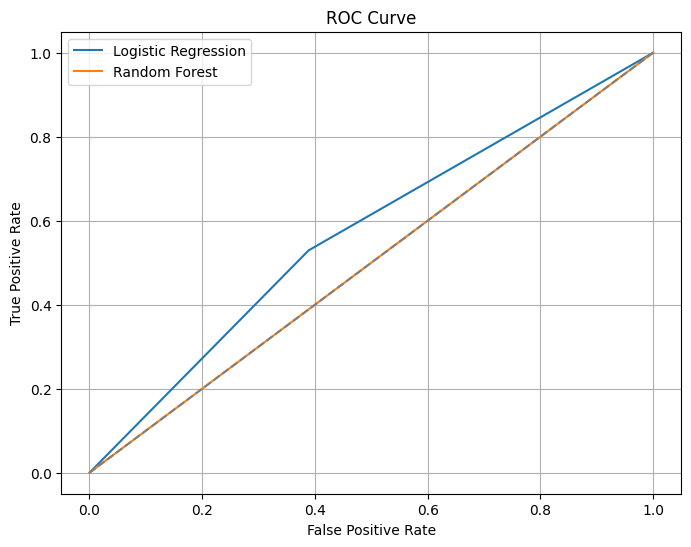

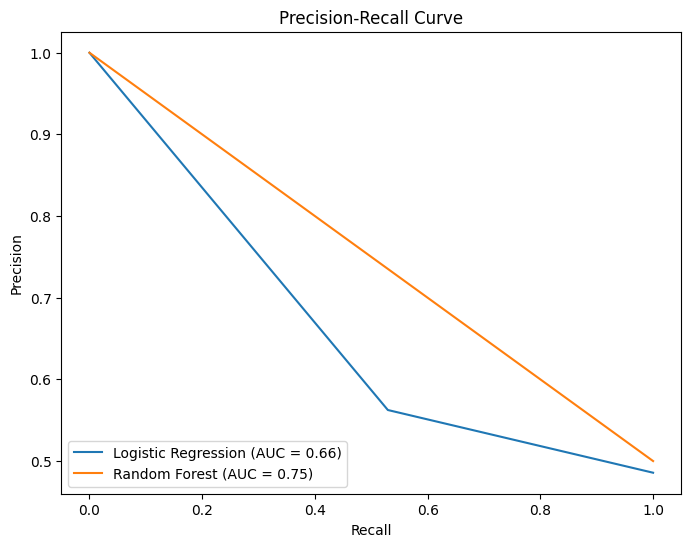

In [56]:
# look at performance for cotrain 1 model

lr_accuracy = cotrain_mod1_performance["lr_accuracy"]
rf_accuracy = cotrain_mod1_performance["rf_accuracy"]
lr_f1_score = cotrain_mod1_performance["lr_f1_score"]
rf_f1_score = cotrain_mod1_performance["rf_f1_score"]
lr_balanced_accuracy = cotrain_mod1_performance["lr_balanced_accuracy"]
rf_balanced_accuracy = cotrain_mod1_performance["rf_balanced_accuracy"]
lr_precision = cotrain_mod1_performance["lr_precision"]
rf_precision = cotrain_mod1_performance["rf_precision"]
lr_recall = cotrain_mod1_performance["lr_recall"]
rf_recall = cotrain_mod1_performance["rf_recall"]


# get precision-recall curves from the dictionary
lr_precision_curve, lr_recall_curve = cotrain_mod1_performance["lr_precision_recall_curve"]
rf_precision_curve, rf_recall_curve = cotrain_mod1_performance["rf_precision_recall_curve"]

# compute AUC for precision-recall curves
lr_pr_auc = auc(lr_recall_curve, lr_precision_curve)
rf_pr_auc = auc(rf_recall_curve, rf_precision_curve)

# # Compute average metrics
num_classifiers = 2  # Number of metrics to average
average_lr_accuracy = (lr_accuracy + rf_accuracy) / num_classifiers
average_lr_f1_score = (lr_f1_score + rf_f1_score) / num_classifiers
average_lr_balanced_accuracy = (lr_balanced_accuracy + rf_balanced_accuracy) / num_classifiers
average_lr_precision = (lr_precision + rf_precision) / num_classifiers
average_lr_recall = (lr_recall + rf_recall) / num_classifiers
average_lr_auc = (lr_pr_auc+rf_pr_auc) / num_classifiers

print("Average Metrics:")
print(f"Accuracy: {average_lr_accuracy}")
print(f"F1 Score: {average_lr_f1_score}")
print(f"Balanced Accuracy: {average_lr_balanced_accuracy}")
print(f"Precision: {average_lr_precision}")
print(f"Recall: {average_lr_recall}")

lr_fpr, lr_tpr = cotrain_mod1_performance["lr_roc_curve"]
rf_fpr, rf_tpr = cotrain_mod1_performance["rf_roc_curve"]

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label="Logistic Regression")
plt.plot(rf_fpr, rf_tpr, label="Random Forest")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(lr_recall_curve, lr_precision_curve, label='Logistic Regression (AUC = %0.2f)' % lr_pr_auc)
plt.plot(rf_recall_curve, rf_precision_curve, label='Random Forest (AUC = %0.2f)' % rf_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


## Logistic regression model training, testing, and performance evaluation with HPO and DisGeNET data

{'disgenet_test_accuracy': 0.4857142857142857, 'disgenet_f1_score': 0.6538461538461539, 'disgenet_lr_balanced_accuracy': 0.4857142857142857, 'disgenet_lr_precision': 1.0, 'disgenet_lr_recall': 0.4857142857142857, 'disgenet_lr_report': '              precision    recall  f1-score   support\n\n           0       0.00      0.00      0.00         0\n           1       1.00      0.49      0.65        35\n\n    accuracy                           0.49        35\n   macro avg       0.50      0.24      0.33        35\nweighted avg       1.00      0.49      0.65        35\n', 'FPR': array([0., 1.]), 'TPR': array([0., 1.]), 'disgenet_auc': 0.75}


/Users/karlavelalopez/Desktop/big_data_science/.venv_big_data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/karlavelalopez/Desktop/big_data_science/.venv_big_data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karlavelalopez/Desktop/big_data_science/.venv_big_data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karlavelalopez/Desktop/big_data_science/.ve

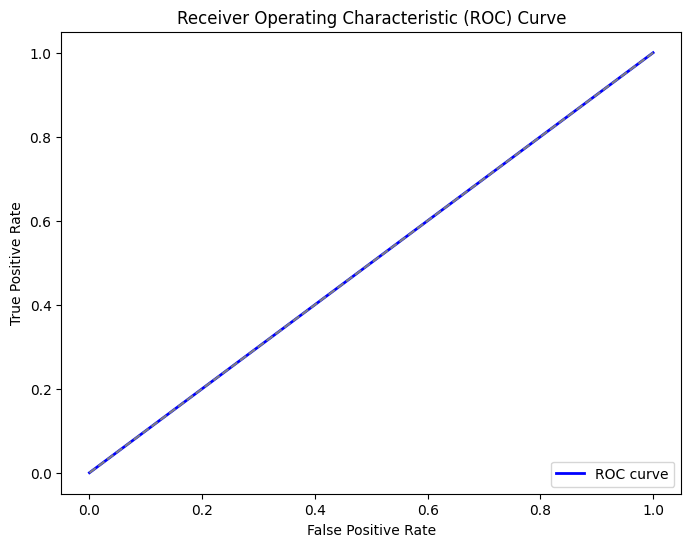

0.7428571428571429


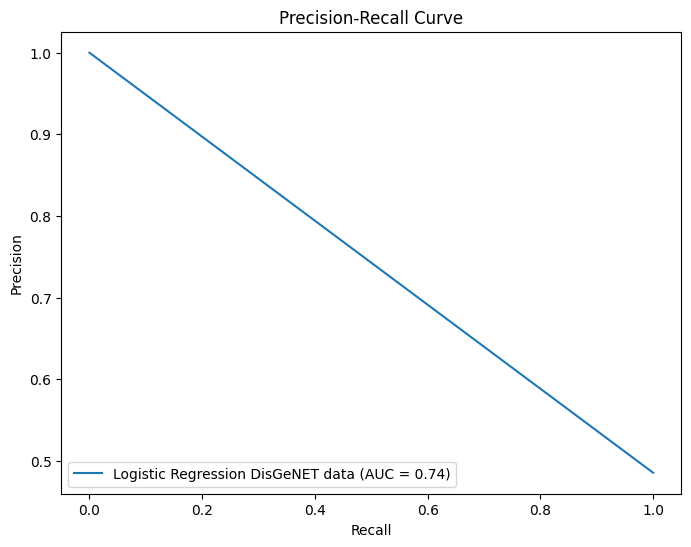

In [66]:
# just logistic regression disgenet


# Train the logistic regression model
lr_classifier.fit(X_train_disgenet, y_train_disgenet)
y_pred_test = lr_classifier.predict(X_test_disgenet)

disgenet_metrics = {
    "disgenet_test_accuracy" : accuracy_score(y_test_disgenet, y_pred_test),
    "disgenet_f1_score" :f1_score( y_test_disgenet, y_pred_test),
    "disgenet_lr_balanced_accuracy" : balanced_accuracy_score(y_pred_test, y_test_disgenet),
    "disgenet_lr_precision": precision_score(y_pred_test, y_test_disgenet),
    "disgenet_lr_recall" : recall_score(y_pred_test, y_test_disgenet),
    "disgenet_lr_report" : classification_report(y_pred_test, y_test_disgenet),
    "FPR": roc_curve(y_test_disgenet, y_pred_test)[0],
    "TPR": roc_curve(y_test_disgenet, y_pred_test)[1],
     "disgenet_auc" : auc(lp_recall_curve, lp_precision_curve)

}
print(disgenet_metrics)
fpr = disgenet_metrics["FPR"]
tpr = disgenet_metrics["TPR"]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


disgenet_lr_precision_curve, disgenet_lr_recall_curve, _ = precision_recall_curve(y_test_disgenet, y_pred_test)
disgenet_lr_pr_auc = auc(disgenet_lr_recall_curve, disgenet_lr_precision_curve)



# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(disgenet_lr_recall_curve, disgenet_lr_precision_curve, label='Logistic Regression DisGeNET data (AUC = %0.2f)' % disgenet_lr_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()



{'hpo_test_accuracy': 0.5035169988276671, 'hpo_f1_score': 0.5002949852507375, 'hpo_balanced_accuracy': 0.5035175837951966, 'hpo_precision': 0.4970691676436108, 'hpo_recall': 0.503562945368171, 'hpo_report': '              precision    recall  f1-score   support\n\n           0       0.51      0.50      0.51       864\n           1       0.50      0.50      0.50       842\n\n    accuracy                           0.50      1706\n   macro avg       0.50      0.50      0.50      1706\nweighted avg       0.50      0.50      0.50      1706\n', 'FPR': array([0.        , 0.49003517, 1.        ]), 'TPR': array([0.        , 0.49706917, 1.        ])}


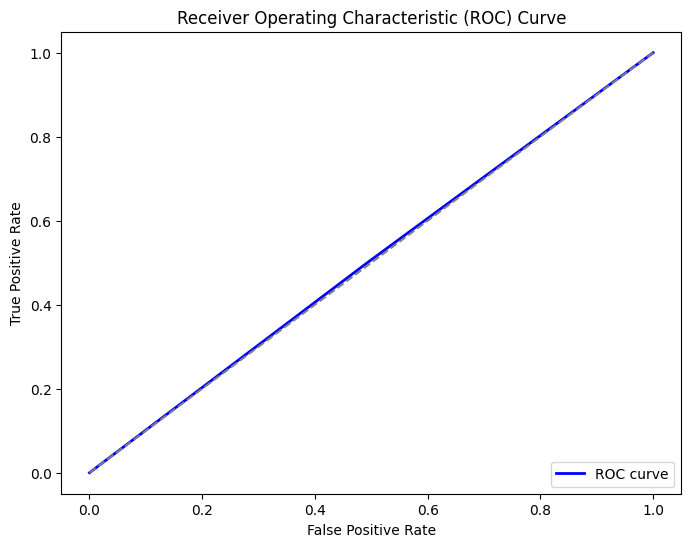

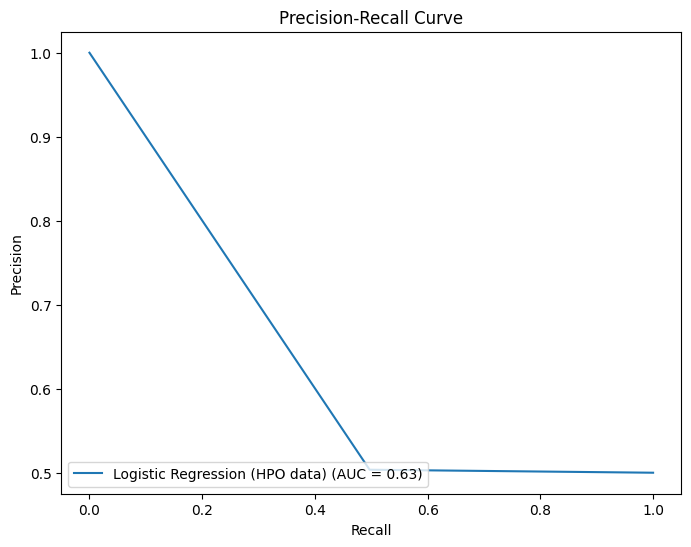

In [58]:
lr_classifier.fit(X_train_hpo, y_train_hpo)
hpo_y_pred_test = lr_classifier.predict(X_test_hpo)
# Calculate accuracy
hpo_metrics = {
    "hpo_test_accuracy" : accuracy_score(y_test_hpo, hpo_y_pred_test),
    "hpo_f1_score" : f1_score(hpo_y_pred_test, y_test_hpo),
    "hpo_balanced_accuracy" : balanced_accuracy_score(hpo_y_pred_test, y_test_hpo),
    "hpo_precision" : precision_score(hpo_y_pred_test, y_test_hpo),
    "hpo_recall" : recall_score(hpo_y_pred_test, y_test_hpo),
    "hpo_report" : classification_report(hpo_y_pred_test, y_test_hpo),
    "FPR": roc_curve(y_test_hpo, hpo_y_pred_test)[0],
    "TPR": roc_curve(y_test_hpo, hpo_y_pred_test)[1]
    
}
print(hpo_metrics)

fpr = hpo_metrics["FPR"]
tpr = hpo_metrics["TPR"]

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

hpo_lr_precision_curve, hpo_lr_recall_curve, _ = precision_recall_curve(y_test_hpo, hpo_y_pred_test)
hpo_lr_pr_auc = auc(hpo_lr_recall_curve, hpo_lr_precision_curve)


# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(hpo_lr_recall_curve, hpo_lr_precision_curve, label='Logistic Regression (HPO data) (AUC = %0.2f)' % hpo_lr_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


## Cotrain model 2 training, testing, and performance evaluation (Logistic Regression + Label Propagation)

In [59]:


cotrain_mod2_performance, deci_lr_pred, deci_lp_pred, int_lr_pred, int_lp_pred, predictions_lp, pred_lr= co_train_lr_label_prop(lr_classifier, label_propagation, X_train_disgenet, X_train_hpo,
                                       y_train_disgenet, y_train_hpo, new_unlabled_disgenet, new_unlabled_hpo,
                                       X_test_disgenet, X_test_hpo, y_test_disgenet, y_test_hpo, .5, adj_matrix_embeddings)

# Save performance results
with open('perf_metrics_lr_lp.txt', 'w') as f:
    for key, value in cotrain_mod2_performance.items():
        f.write('%s:%s\n' % (key, value))

# Save logistic regression gene predictions
with open('lr_gene_predictions_cotrainmod2.txt', 'w') as f:
    for key, value in deci_lr_pred.items():
        f.write('%s:%s\n' % (key, value))

# Save random forest gene predictions
with open('label_prop_gene_predictions.txt', 'w') as f:
    for key, value in deci_lp_pred.items():
        f.write('%s:%s\n' % (key, value))



/Users/karlavelalopez/Desktop/big_data_science/.venv_big_data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2394: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/karlavelalopez/Desktop/big_data_science/.venv_big_data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karlavelalopez/Desktop/big_data_science/.venv_big_data/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/karlavelalopez/Desktop/big_data_science/.ve

Average Metrics:
Accuracy: 0.5357142857142857
F1 Score: 0.6060606060606061
Balanced Accuracy: 0.5353618421052632
Precision: 0.7647058823529411
Recall: 0.53125


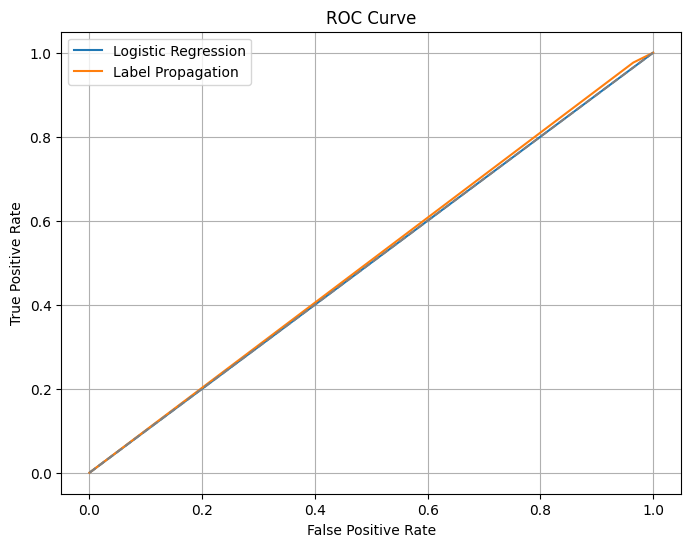

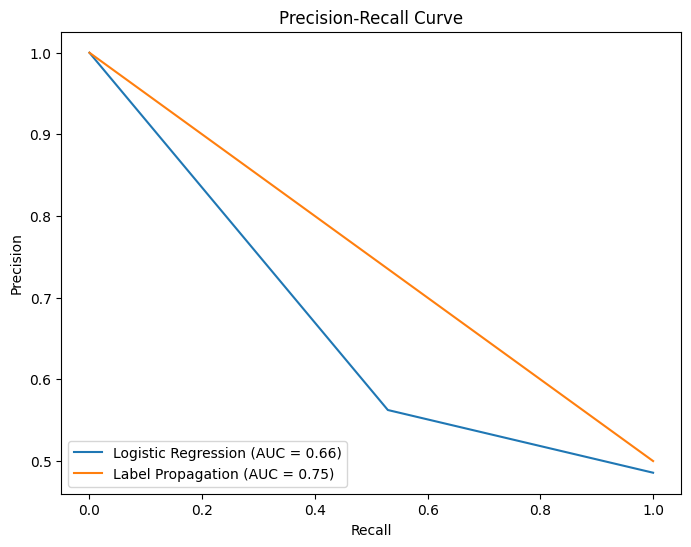

In [60]:
# look at peformance 

lr_accuracy = cotrain_mod2_performance["lr_accuracy"]
lp_accuracy = cotrain_mod2_performance["lp_accuracy"]
lr_f1_score = cotrain_mod2_performance["lr_f1_score"]
lp_f1_score = cotrain_mod2_performance["lp_f1_score"]
lr_balanced_accuracy = cotrain_mod2_performance["lr_balanced_accuracy"]
lp_balanced_accuracy = cotrain_mod2_performance["lp_balanced_accuracy"]
lr_precision = cotrain_mod2_performance["lr_precision"]
lp_precision = cotrain_mod2_performance["lp_precision"]
lr_recall = cotrain_mod2_performance["lr_recall"]
lp_recall = cotrain_mod2_performance["lp_recall"]


# get precision-recall curves from the dictionary
lr_precision_curve, lr_recall_curve = cotrain_mod1_performance["lr_precision_recall_curve"]
lp_precision_curve, lp_recall_curve = cotrain_mod1_performance["rf_precision_recall_curve"]

# compute AUC for precision-recall curves
lr_pr_auc = auc(lr_recall_curve, lr_precision_curve)
lp_pr_auc = auc(lp_recall_curve, lp_precision_curve)


# # Compute average metrics
num_classifiers = 2  # Number of metrics to average
cotrain2_accuracy = (lr_accuracy + lp_accuracy) / num_classifiers
cotrain2_f1_score = (lr_f1_score + lp_f1_score) / num_classifiers
cotrain2_balanced_accuracy = (lr_balanced_accuracy + lp_balanced_accuracy) / num_classifiers
cotrain2_precision = (lr_precision + lp_precision) / num_classifiers
cotrain2_recall = (lr_recall + lp_recall) / num_classifiers
cotrain2_auc = (lr_pr_auc+lp_pr_auc) / num_classifiers

print("Average Metrics:")
print(f"Accuracy: {average_lr_accuracy}")
print(f"F1 Score: {average_lr_f1_score}")
print(f"Balanced Accuracy: {average_lr_balanced_accuracy}")
print(f"Precision: {average_lr_precision}")
print(f"Recall: {average_lr_recall}")

lr_fpr, lr_tpr = cotrain_mod2_performance["lr_roc_curve"]
lp_fpr, lp_tpr = cotrain_mod2_performance["lp_roc_curve"]

plt.figure(figsize=(8, 6))
plt.plot(lr_fpr, lr_tpr, label="Logistic Regression")
plt.plot(lp_fpr, lp_tpr, label="Label Propagation")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


# Plot precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(lr_recall_curve, lr_precision_curve, label='Logistic Regression (AUC = %0.2f)' % lr_pr_auc)
plt.plot(rf_recall_curve, rf_precision_curve, label='Label Propagation (AUC = %0.2f)' % lp_pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()




[0.4857142857142857, 0.6538461538461539, 0.4857142857142857, 1.0, 0.4857142857142857, 0.7428571428571429]
[0.5035169988276671, 0.5002949852507375, 0.5035175837951966, 0.4970691676436108, 0.503562945368171, 0.6260487645949881]
[0.5357142857142857, 0.6060606060606061, 0.5353618421052632, 0.7647058823529411, 0.53125, 0.7051207983193277]
[0.495787975213532, 0.6589278597050618, 0.5186119737750172, 0.9882766705744431, 0.4943668046928916, 0.7051207983193277]


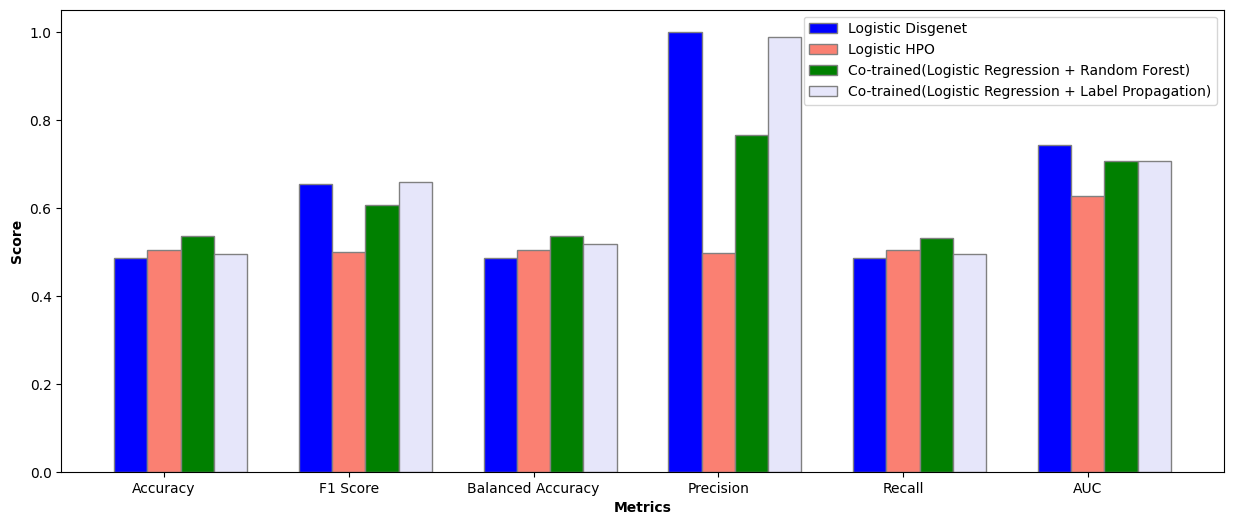

In [70]:

#define metric names
metric_names = ['Accuracy', 'F1 Score', 'Balanced Accuracy', 'Precision', 'Recall', 'AUC']

# get values for each model
disgenet_lr_metrics = [disgenet_metrics['disgenet_test_accuracy'],
                       disgenet_metrics['disgenet_f1_score'],
                       disgenet_metrics['disgenet_lr_balanced_accuracy'],
                       disgenet_metrics['disgenet_lr_precision'],
                       disgenet_metrics['disgenet_lr_recall'],
                       disgenet_lr_pr_auc]

print(disgenet_lr_metrics)
hpo_lr_metrics = [hpo_metrics['hpo_test_accuracy'],
                  hpo_metrics["hpo_f1_score"],
                  hpo_metrics["hpo_balanced_accuracy"],
                  hpo_metrics["hpo_precision"],
                  hpo_metrics["hpo_recall"],
                  hpo_lr_pr_auc]
print(hpo_lr_metrics)

co_train1_metrics = [average_lr_accuracy,
                    average_lr_f1_score,
                    average_lr_balanced_accuracy,
                    average_lr_precision,
                    average_lr_recall,
                    average_lr_auc]
print(co_train1_metrics)
co_train2_metrics = [cotrain2_accuracy ,
                    cotrain2_f1_score, 
                    cotrain2_balanced_accuracy,
                    cotrain2_precision ,
                    cotrain2_recall,
                    cotrain2_auc]
print(co_train2_metrics)
# set the bar width
bar_width = 0.18

# set the positions of the bars on the x-axis
r1 = np.arange(len(metric_names))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# create the bar plot
plt.figure(figsize=(15, 6))
plt.bar(r1, disgenet_lr_metrics, color='b', width=bar_width, edgecolor='grey', label='Logistic Disgenet')
plt.bar(r2, hpo_lr_metrics, color='salmon', width=bar_width, edgecolor='grey', label='Logistic HPO')
plt.bar(r3, co_train1_metrics, color='green', width=bar_width, edgecolor='grey', label='Co-trained(Logistic Regression + Random Forest)')
plt.bar(r4, co_train2_metrics, color='lavender', width=bar_width, edgecolor='grey', label='Co-trained(Logistic Regression + Label Propagation)')

# add xticks on the middle of the group bars
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(metric_names))], metric_names)

# create legend & Show graphic
plt.legend()
plt.show()


In [71]:
print("Length of disgenet_lr_metrics:", len(disgenet_lr_metrics))
print("Length of hpo_lr_metrics:", len(hpo_lr_metrics))
print("Length of co_train1_metrics:", len(co_train1_metrics))
print("Length of co_train2_metrics:", len(co_train2_metrics))
